# Set up Software

Notice (26.10.2022): 

Google Colab now has hmmlearn 0.2.8

Replaced: hmm.MultinomialHMM $\to$ hmm.CategoricalHMM

In [1]:
!pip install hmmlearn

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from hmmlearn import hmm

# some convenience functions
def HMM_inspect(Z,X,t=50):
  z_str = ''.join(str(z) for z in Z.flatten()[0:t])
  x_str = ''.join(str(x) for x in X.flatten()[0:t])
  print('Z: ',z_str)
  print('X: ',x_str)

  bs=list(np.arange(0,6,0.5))
  plt.hist(X[Z == 0], label='Z=0', alpha=0.5, bins=bs)
  plt.hist(X[Z == 1], label='Z=1', alpha=0.5, bins=bs)
  plt.xlabel('observation X')
  plt.legend()
  plt.show()

# plot matrix (with title and numbers)
def plotMatrix(ax, mat, title, cm, normalizer):
  ax.imshow(mat, cmap=cm, norm=normalizer)
  for (j,i),label in np.ndenumerate(mat):
    ax.text(i,j,np.round(label,2),ha='center',va='center')
    ax.set_title(title)

# compare two models
def compareHMM(model, model_fit):
  ## Visualization ###
  my_cm=plt.cm.Blues        # set color-map
  normalizer=Normalize(0,1) # set common color code for trans and emission probs 

  fig, ax = plt.subplots(3, 2, 
      gridspec_kw={'width_ratios': [1, 3], 'height_ratios': [1, 1, 0.1]},
      figsize=(10,7))

  plotMatrix(ax[0,0], model.transmat_, 'trans - orig', my_cm, normalizer)
  plotMatrix(ax[0,1], model.emissionprob_, 'emissions - orig', my_cm, normalizer)
  plotMatrix(ax[1,0], model_fit.transmat_, 'trans - fit', my_cm, normalizer)
  plotMatrix(ax[1,1], model_fit.emissionprob_, 'emissions - fit', my_cm, normalizer)

  # add colorbar with common color scale (set by im)
  im = plt.cm.ScalarMappable( cmap=my_cm, norm=normalizer) 
  fig.colorbar(im, cax=ax[2,0], orientation='horizontal')
  fig.colorbar(im, cax=ax[2,1], orientation='horizontal')
  plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# The Ingredients

- States $Z$: { 0 = fair, 1 = biased }; 
- Observations $X$: { 0, 1, 2, 3, 4, 5 }
- Parameters $\Theta$:

\begin{align}
    P(Z_0) &= \begin{bmatrix} 0.5 & 0.5  \end{bmatrix} \\ \\
    P(Z_t | Z_{t-1}) & = \begin{bmatrix} 0.95 & 0.05 \\ 0.25 & 0.75 \end{bmatrix} \\ \\
    P(X_t | Z_t) & =  \begin{bmatrix} 1/6 & 1/6 &  1/6 & 1/6 & 1/6 & 1/6 \\ 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.5 \end{bmatrix} \\
\end{align}


# Generating states and observations

In [2]:
pf = [1./6 ] *6           # fair emission probabilities
pb = [1./10] *5 + [1/2]   # biased emission probabilities

np.random.seed(42)
model_gen = hmm.CategoricalHMM(n_components=2)
model_gen.startprob_ = np.array([0.5, 0.5])                     # initial state prob
model_gen.transmat_  = np.array([[0.95, 0.05], [0.25, 0.75]])  # transition prob
model_gen.emissionprob_ =  np.array([pf, pb])                  # emission prob

X,Z = model_gen.sample(5000)

# Fit the data: several start points

new best:  0 -8907.84168625088
new best:  2 -8894.97766303
new best:  3 -8894.449120233869


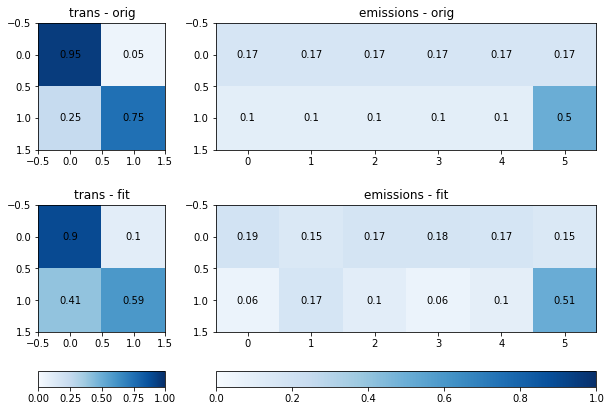

In [4]:
np.random.seed(42)
best_model, best_score = None, None

for i in range(10):
  model_fit = hmm.CategoricalHMM( 
      n_components=2,     # number of states
      n_iter=1000,        # number of iterations per initialization
      init_params='ste'   # which parameters to initialize automatically 
      )
  
  # manual initializations (optional)
  #model_fit.transmat_ = np.array([ [0.9, 0.1], [0.1, 0.9]])

  model_fit.fit(X)
  score = model_fit.score(X)

  if (best_model is None or score > best_score):
    best_score = score
    best_model = model_fit
    print('new best: ', i, best_score)

compareHMM(model_gen, best_model)

In [6]:
_, Zg = model_gen.decode(X)
_, Zb = best_model.decode(X)

print('differences (Zg-Z):  ', np.sum(Zg != Z))
print('differences (Zb-Z):  ', np.sum(Zb != Z))

differences (Zg-Z):   795
differences (Zb-Z):   763


In [12]:
def plotMatrix1(mat, title):
  plt.imshow(mat, cmap=plt.cm.Blues)
  for (j,i),label in np.ndenumerate(mat):
    plt.text(i,j,np.round(label,2),ha='center',va='center')
    plt.title(title)
  plt.show()

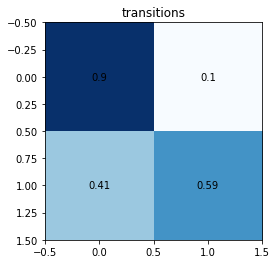

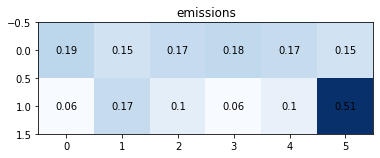

In [13]:
plotMatrix1(best_model.transmat_, 'transitions')
plotMatrix1(best_model.emissionprob_, 'emissions')


**Messages:**

- Learning = Fitting is computationally the most demanding step
- The Baum-Welch Algorithm only delivers **local maxima** - run it several times to explore other initial conditions
- **hyperparameters**: number of iterations, initial estimates
- The number of components needs to be chosen wisely (limits of unsupervised learning)
- More data helps, but fitting will take longer
- The state labels may swap
- Although state transitions and emission probabilities may be predicted quite accurately, predicting the correct state path is much harder.

